Alice original bits
[0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
Alice original bases
[<Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>]
Alice circut is:
Bob original bases
[<Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.Z: 0>, <Basis.X: 1>, <Basis.X: 1>

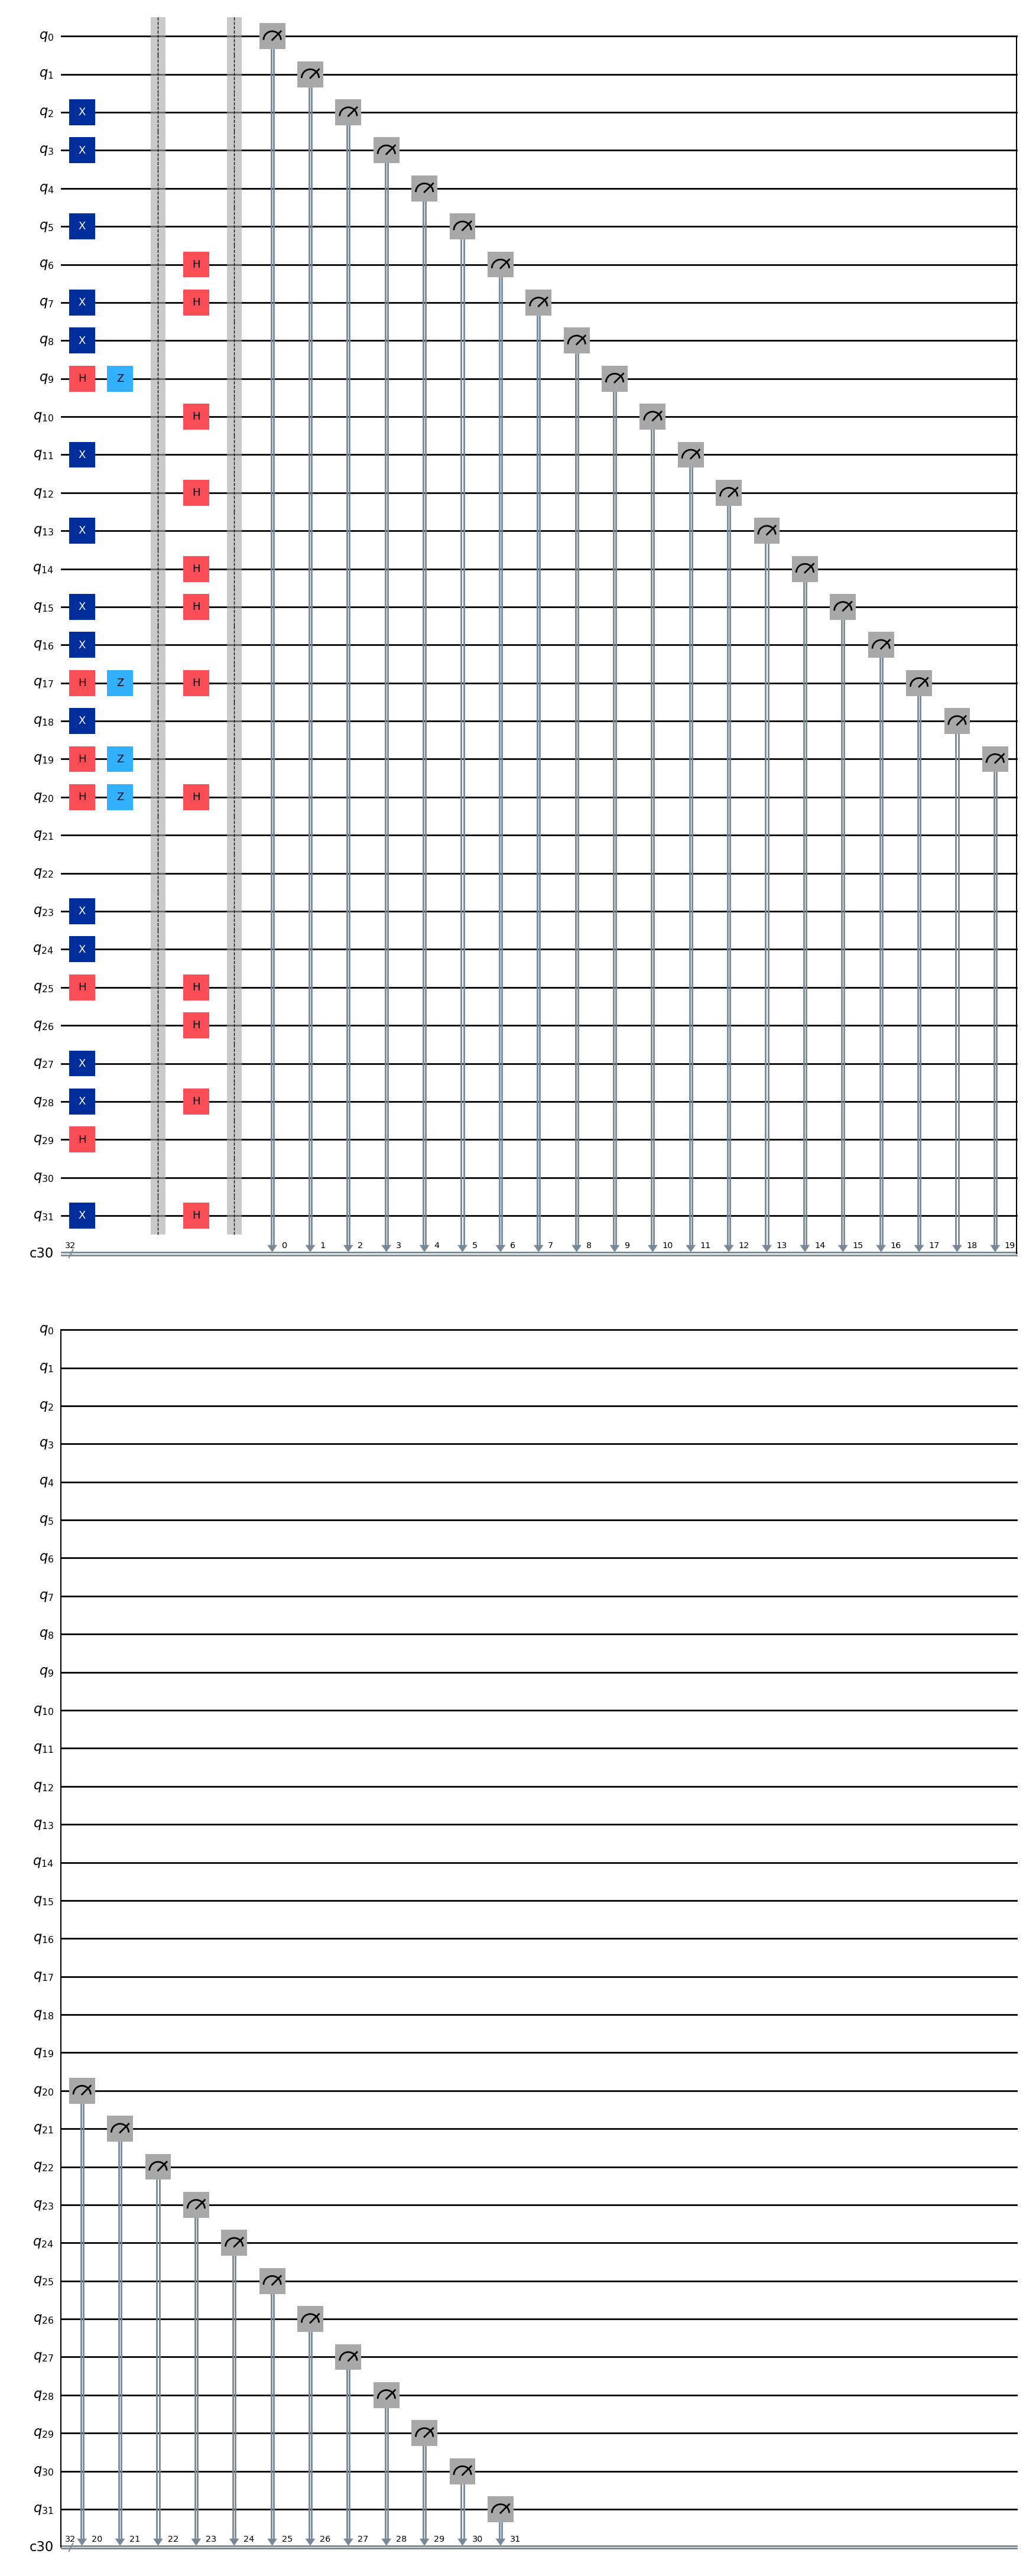

In [38]:
import random
from enum import Enum
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

class Basis(Enum):
    Z = 0
    X = 1

# Define the quantum circuit as a global variable
qc = None

class Alice:
    def __init__(self, num_qubits: int):
        global qc
        qc = QuantumCircuit(num_qubits)
        self.num_qubits = num_qubits
        self.bases = [random.choice([Basis.Z, Basis.X]) for _ in range(num_qubits)]
        self.bits = [random.choice([0, 1]) for _ in range(num_qubits)]
        print("Alice original bits")
        print(self.bits)
        print("Alice original bases")
        print(self.bases)

    def prepare_qubits(self):
        global qc
        for i in range(self.num_qubits):
            if self.bases[i] == Basis.Z:
                # Z basis
                if self.bits[i] == 1:
                    qc.x(i)  # Prepare |1>
            else:
                # X basis
                qc.h(i)    # |0> -> |+>
                if self.bits[i] == 1:
                    qc.z(i) # |+> -> |->
                # X basis
                # if self.bits[i] == 1:
                #     qc.x(i) # |+> -> |->
                # qc.h(i)    # |0> -> |+>
                
        qc.barrier()
    def sift_key(self, bob_bases):
        # Find indices where Alice’s and Bob’s bases match
        matching_indices = [i for i in range(self.num_qubits) if self.bases[i] == bob_bases[i]]
        # Extract the bits that correspond to matching bases
        sifted_bits = [self.bits[i] for i in matching_indices]
        return sifted_bits, matching_indices









class Bob:
    def __init__(self, num_qubits: int):
        self.num_qubits = num_qubits
        self.bases = [random.choice([Basis.Z, Basis.X]) for _ in range(num_qubits)]
        self.measurements = None  # Will store the measurement results
        print("Bob original bases")
        print(self.bases)
    def measure_qubits(self):
        global qc
        # Add a classical register if not present
        if len(qc.cregs) == 0:
            qc.add_register(ClassicalRegister(self.num_qubits))
        
        for i in range(self.num_qubits):
            if self.bases[i] == Basis.X:
                qc.h(i)  # Rotate to measure in X basis by applying H before measurement
        qc.barrier()
        for i in range(self.num_qubits):
            qc.measure(i, i)
        
        # Execute the circuit on a simulator
        simulator = AerSimulator()
        # compiled_circuit = transpile(qc, simulator,coupling_map=None)
        # job = simulator.run(compiled_circuit, shots=1024)
        job = simulator.run(qc, shots=1)
        result = job.result()
        counts = result.get_counts()
        print(result.get_counts())
        # counts is a dictionary like {'010101...': 1}, we extract the key
        measured_string = list(counts.keys())[0] ## TODO GET KEY WITH HIGHEST PROB
        # Convert measured_string into a list of ints (0/1)
        self.measurements = [int(bit) for bit in measured_string[::-1]]
        print("Bob Measurments is:")
        print(self.measurements)

    def sift_key(self, matching_indices):
        # Return the bits that correspond to the matching bases
        if self.measurements is None:
            raise ValueError("No measurements available. Please measure first.")
        sifted_bits = [self.measurements[i] for i in matching_indices]
        for i in matching_indices:
            print(i)
        return sifted_bits


# Create an Alice instance for 100 qubits
alice = Alice(32)

# Call prepare_qubits explicitly
alice.prepare_qubits()

print("Alice circut is:")
qc.draw("mpl")

bob = Bob(32)

qc.draw("mpl")

bob.measure_qubits()

alice_sifted_bits, alice_matching_indices = alice.sift_key(bob.bases)
print("Alice alice_matching_indices is:")
print(alice_matching_indices)
print("Alice alice_sifted_bits is:")
print(alice_sifted_bits)
bob_sifted_bits = bob.sift_key(alice_matching_indices)
print("bob_sifted_bits is:")
print(bob_sifted_bits)

qc.draw("mpl")